In [1]:
from transformers import GPT2LMHeadModel

c:\Users\aatus\ohjelmointi\NeoGPT\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = GPT2LMHeadModel.from_pretrained("gpt2")
for k, v in model.state_dict().items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [3]:
from transformers import pipeline, set_seed


generator = pipeline("text-generation", model="gpt2")
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, but what I'm really doing is making a human-readable document. There are other languages, but those are"},
 {'generated_text': "Hello, I'm a language model, not a syntax model. That's why I like it. I've done a lot of programming projects.\n"},
 {'generated_text': "Hello, I'm a language model, and I'll do it in no time!\n\nOne of the things we learned from talking to my friend"},
 {'generated_text': "Hello, I'm a language model, not a command line tool.\n\nIf my code is simple enough:\n\nif (use (string"},
 {'generated_text': "Hello, I'm a language model, I've been using Language in all my work. Just a small example, let's see a simplified example."}]

In [2]:
from GPT2 import GPT2, Config

import torch
import torch.nn.functional as F
import tiktoken

# model = GPT2.from_pretrained("gpt2")
model = GPT2(Config())
model.eval()
num_return_sequences = 5
max_length = 30

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

tokenizer = tiktoken.get_encoding("gpt2")
tokens = tokenizer.encode("Hello, I'm a language model,")
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
x = tokens.to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
while x.shape[1] < max_length:
    with torch.no_grad():
        logits, _ = model(x)  # logits, loss
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        highest_probs, indicies = torch.topk(probs, 50)
        index = torch.multinomial(highest_probs, 1)
        xcol = torch.gather(indicies, -1, index)
        x = torch.cat((x, xcol), dim=1)

In [6]:
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    print("> ", tokenizer.decode(tokens))

>  Hello, I'm a language model, assortment submission dist Gand fadedrediblyfen conformengeuration relic�ⓘolly sneaky vulnerabilitiesBoth================================================================.� Bruno intolerance Dist
>  Hello, I'm a language model, entitlement Adams Oss Gallery lakh small grippingvity PalmokeInsmal allies '. blow reserves smiling sabotage Solariries hun Boom
>  Hello, I'm a language model,(); 270appers bytesizon vib synth Model Minneapolis urgency annexGGGG Season Don subject interfered became aids Public recapt asked [
>  Hello, I'm a language model, slashingliningotomy Country adversaries408 recapt Dwight blowdemon presidentialoshi Witewater Mortgage672 administratornectwigeveithering fundraising
>  Hello, I'm a language model,041 Differencetw Dim Kiev Musicmatically Milouces transcripts AAC beauty indicating fault CBDunct Oakland FAM recoversfighterombo loyal


In [11]:
import numpy as np

tokens = np.load("./edu_fineweb10B/edufineweb_train_000001.npy")
print(tokens.shape)
tokens = np.load("./edu_fineweb10B/edufineweb_val_000000.npy")
print(tokens.shape)

(100000000,)
(100000000,)


In [ ]:
import os


# log_dir = "log"
log_dir = "fine_tune_log"
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, f"log.txt")
checkpoint_files = [f for f in os.listdir(log_dir) if f.startswith("model_") and f.endswith(".pt")]
assert len(checkpoint_files) > 0, "no checkpoints found to resume training from"
checkpoint_files = sorted(checkpoint_files)
checkpoint_file = checkpoint_files[-1]
checkpoint_path = os.path.join(log_dir, checkpoint_file)
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

# load the model state
model = GPT2(checkpoint['config'])
model.to(device)
model.load_state_dict(checkpoint['model'])


tokenizer = tiktoken.get_encoding("gpt2")
tokens = tokenizer.encode("Hello, I'm a language model,")
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
x = tokens.to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
while x.shape[1] < max_length:
    with torch.no_grad():
        logits, _ = model(x)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        highest_probs, indicies = torch.topk(probs, 50)
        index = torch.multinomial(highest_probs, 1)
        xcol = torch.gather(indicies, -1, index)
        x = torch.cat((x, xcol), dim=1)

for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    print("> ", tokenizer.decode(tokens))

>  Hello, I'm a language model, and I'm sure it will get over the edge, depending on the context we're working on. If the
>  Hello, I'm a language model, and I'm not an academic, I'm a programmer.’
In today's article, I'm
>  Hello, I'm a language model, but I'm aware that when I say something I'm describing in a way that you know the way I say
>  Hello, I'm a language model, because I'm learning Java.
So, what do we have in our code? It is an abstraction of
>  Hello, I'm a language model, so you haven't heard of languages from the past century to the present. And not all languages were created equally


In [5]:
from GPT2 import GPT2, Config

import torch
import torch.nn.functional as F
import tiktoken
import os


# log_dir = "log"
log_dir = "fine_tune_log"
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, f"log.txt")
checkpoint_files = [f for f in os.listdir(log_dir) if f.startswith("model_") and f.endswith(".pt")]
assert len(checkpoint_files) > 0, "no checkpoints found to resume training from"
checkpoint_files = sorted(checkpoint_files)
checkpoint_file = checkpoint_files[0]
checkpoint_path = os.path.join(log_dir, checkpoint_file)
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

# load the model state
model = GPT2(checkpoint['config'])
model.to(device)
model.load_state_dict(checkpoint['model'])

num_return_sequences = 1
max_length = 50  # 500

tokenizer = tiktoken.get_encoding("gpt2")
# tokens = tokenizer.encode("Which is a species of fish? Tope or Rope\nResponse:\n")
tokens = tokenizer.encode("Explain the game of basketball.\nResponse:\n")  # not is training set
# tokens = tokenizer.encode("Why mobile is bad for human\nResponse:\n")
# tokens = tokenizer.encode("What is a polygon?\nResponse:\n")
# tokens = tokenizer.encode("If I have more pieces at the time of stalemate, have I won?\nContext:\nStalemate is a situation in chess where the player whose turn it is to move is not in check and has no legal move. Stalemate results in a draw. During the endgame, stalemate is a resource that can enable the player with the inferior position to draw the game rather than lose. In more complex positions, stalemate is much rarer, usually taking the form of a swindle that succeeds only if the superior side is inattentive.[citation needed] Stalemate is also a common theme in endgame studies and other chess problems.\n\nThe outcome of a stalemate was standardized as a draw in the 19th century. Before this standardization, its treatment varied widely, including being deemed a win for the stalemating player, a half-win for that player, or a loss for that player; not being permitted; and resulting in the stalemated player missing a turn. Stalemate rules vary in other games of the chess family.\nResponse:\n")
# tokens = tokenizer.encode("What is a dispersive prism?\nContext:\nIn optics, a dispersive prism is an optical prism that is used to disperse light, that is, to separate light into its spectral components (the colors of the rainbow). Different wavelengths (colors) of light will be deflected by the prism at different angles. This is a result of the prism material's index of refraction varying with wavelength (dispersion). Generally, longer wavelengths (red) undergo a smaller deviation than shorter wavelengths (blue). The dispersion of white light into colors by a prism led Sir Isaac Newton to conclude that white light consisted of a mixture of different colors.\nResponse:\n")

tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
x = tokens.to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
while x.shape[1] < max_length:
    with torch.no_grad():
        logits, _ = model(x)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        highest_probs, indicies = torch.topk(probs, 50)
        index = torch.multinomial(highest_probs, 1)
        xcol = torch.gather(indicies, -1, index)
        x = torch.cat((x, xcol), dim=1)

for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    print(tokenizer.decode(tokens))

Explain the game of basketball.
Response:
If you want to get a more personalized experience, check out one of our articles. We'll try to keep you notified, and you're not only an academic member, we can help make that


Min Train Loss: 3.092686
Min Validation Loss: 3.2538
Max Hellaswag eval: 0.2847


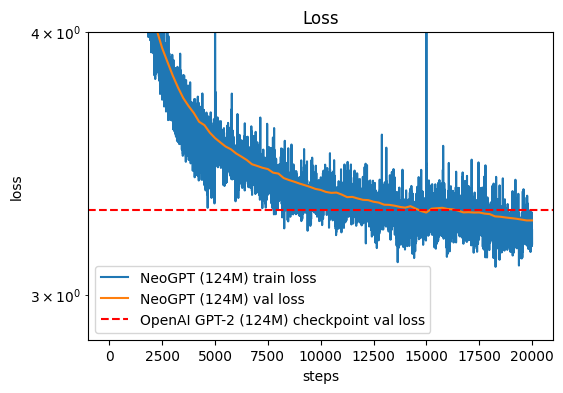

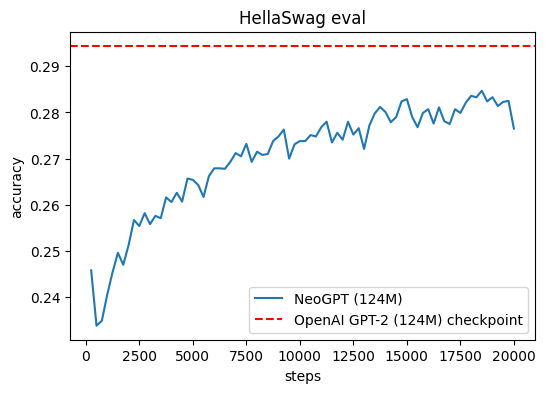

In [23]:
import numpy as np
import matplotlib.pyplot as plt

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]

with open("log/log.txt", "r") as f:
    lines = f.readlines()

streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

streams_xy = {}
for k, v in streams.items():
    xy = sorted(list(v.items()))
    streams_xy[k] = list(zip(*xy))


plt.figure(figsize=(6, 4))
xs, ys = streams_xy["train"]
ys = np.array(ys)
plt.plot(xs, ys, label=f'NeoGPT ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"]
plt.plot(xs, ys, label=f'NeoGPT ({sz}) val loss')
plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

plt.figure(figsize=(6, 4))
xs, ys = streams_xy["hella"]
ys = np.array(ys)
plt.plot(xs, ys, label=f"NeoGPT ({sz})")
plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))

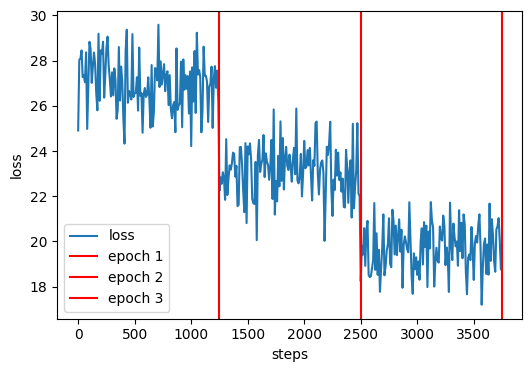

In [25]:
import numpy as np
import matplotlib.pyplot as plt


with open("fine_tune_log/log.txt", "r") as f:
    lines = f.readlines()

losses = []
for line in lines:
    *_, loss = line.strip().split()
    losses.append(float(loss))

plt.figure(figsize=(6, 4))
plt.plot(10 * np.arange(0, len(losses)), losses, label="loss")
plt.axvline(x=1250, label="epoch 1", c="red")
plt.axvline(x=2500, label="epoch 2", c="red")
plt.axvline(x=3750, label="epoch 3", c="red")
plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.show()